In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import os
import tensorflow as tf

2025-07-14 12:19:34.677660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752520774.691478 2045563 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752520774.695723 2045563 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752520774.708188 2045563 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752520774.708199 2045563 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752520774.708201 2045563 computation_placer.cc:177] computation placer alr

In [2]:
# minorized reference
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    #print("Keys: %s" % file.keys())
    ref_d = file['density'][:]
#print(ref_d)
print(ref_d.shape)
minorized_ref_d = (np.sum(ref_d,axis=2))
minorized_ref_d.shape



(64, 64, 64)


(64, 64)

In [3]:
####################################################################################################################################################
def stochastic_density(d,N):
    # poisson model
    #  accurate and fast for all values of N
    # N  = number of MC samples
    assert isinstance(d,np.ndarray)
    assert isinstance(N,(int,float,np.int64,np.float64))
    assert N>0
    ds = np.random.poisson(N*d)/N
    ds*= d.sum()/ds.sum()
    return ds
#end def stochastic_density

####################################################################################################################################################

In [4]:
import tensorflow as tf

def jensen_shannon_divergence_loss(y_true, y_pred):
    y_t = tf.cast(y_true, tf.float32)
    y_p = tf.cast(y_pred, tf.float32)

    y_t = tf.reshape(y_t, [tf.shape(y_t)[0], -1])
    y_p = tf.reshape(y_p, [tf.shape(y_p)[0], -1])

    y_t /= tf.reduce_sum(y_t, axis=1, keepdims=True) + 1e-8
    y_p /= tf.reduce_sum(y_p, axis=1, keepdims=True) + 1e-8

    m = 0.5 * (y_t + y_p)

    kl_true = tf.reduce_sum(y_t * tf.math.log((y_t + 1e-8) / (m + 1e-8)), axis=1)
    kl_pred = tf.reduce_sum(y_p * tf.math.log((y_p + 1e-8) / (m + 1e-8)), axis=1)

    jsd = 0.5 * (kl_true + kl_pred)

    return tf.reduce_mean(jsd)


In [5]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import register_keras_serializable

# === Custom Layer ===
@register_keras_serializable(package="Custom")
class Renormalize(tf.keras.layers.Layer):
    def __init__(self, target_sum=8.0, **kwargs):
        super().__init__(**kwargs)
        self.target_sum = target_sum

    def call(self, inputs):
        x_sum = tf.reduce_sum(inputs, axis=[1, 2, 3], keepdims=True)
        return inputs / (x_sum + 1e-8) * self.target_sum

    def get_config(self):
        config = super().get_config()
        config.update({'target_sum': self.target_sum})
        return config

# === Custom Loss ===
@register_keras_serializable(package="Custom")
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    m = 0.5 * (y_true + y_pred)
    return 0.5 * tf.reduce_mean(
        tf.keras.losses.KLDivergence()(y_true, m) +
        tf.keras.losses.KLDivergence()(y_pred, m)
    )

# === Load Model ===
dae = load_model("DAE.keras")


2025-07-14 12:19:48.319229: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [6]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import register_keras_serializable

# === Custom Layer ===
@register_keras_serializable(package="Custom")
class Renormalize(tf.keras.layers.Layer):
    def __init__(self, target_sum=8.0, **kwargs):
        super().__init__(**kwargs)
        self.target_sum = target_sum

    def call(self, inputs):
        x_sum = tf.reduce_sum(inputs, axis=[1, 2, 3], keepdims=True)
        return inputs / (x_sum + 1e-8) * self.target_sum

    def get_config(self):
        config = super().get_config()
        config.update({'target_sum': self.target_sum})
        return config

# === Custom Loss ===
@register_keras_serializable(package="Custom")
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    m = 0.5 * (y_true + y_pred)
    return 0.5 * tf.reduce_mean(
        tf.keras.losses.KLDivergence()(y_true, m) +
        tf.keras.losses.KLDivergence()(y_pred, m)
    )

# === Load Model ===
cae = load_model("CAE.keras")


In [7]:
50000//50

1000

In [8]:
CAE_JSD[100]

NameError: name 'CAE_JSD' is not defined

In [ ]:
y_test=np.sum(stochastic_density(ref_d,1000000),axis=2)
print(jensen_shannon_divergence_loss(y_test, minorized_ref_d.copy()))
print(dae.predict(y_test.reshape(-1, 64, 64, 1)).shape)

In [ ]:
print(jensen_shannon_divergence_loss(y_test, minorized_ref_d.copy()))
print(jensen_shannon_divergence_loss(dae.predict(y_test.reshape(-1, 64, 64, 1))[0,:,:,0], minorized_ref_d.copy()))
print(jensen_shannon_divergence_loss(cae.predict(y_test.reshape(-1, 64, 64, 1))[0,:,:,0], minorized_ref_d.copy()))

In [10]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import register_keras_serializable
import h5py

# === Custom Components ===
@register_keras_serializable(package="Custom")
class Renormalize(tf.keras.layers.Layer):
    def __init__(self, target_sum=8.0, **kwargs):
        super().__init__(**kwargs)
        self.target_sum = target_sum

    def call(self, inputs):
        x_sum = tf.reduce_sum(inputs, axis=[1, 2, 3], keepdims=True)
        return inputs / (x_sum + 1e-8) * self.target_sum

    def get_config(self):
        config = super().get_config()
        config.update({'target_sum': self.target_sum})
        return config

@register_keras_serializable(package="Custom")
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    m = 0.5 * (y_true + y_pred)
    return 0.5 * tf.reduce_mean(
        tf.keras.losses.KLDivergence()(y_true, m) +
        tf.keras.losses.KLDivergence()(y_pred, m)
    )

# === Load Reference ===
with h5py.File('/global/u2/k/kberard/SCGSR/Research/Diamond/Data/density_tot_ref.h5', 'r') as file:
    ref_d = file['density'][:]  # shape: (64, 64, 64)
minorized_ref_d = np.sum(ref_d, axis=2)  # shape: (64, 64)

# === Find Models and Match to Sample Sizes ===
model_files = [f for f in os.listdir('.') if re.match(r'\d+_(DAE|CAE)\.keras$', f)]
model_dict = {}
for f in model_files:
    match = re.match(r'(\d+)_(DAE|CAE)\.keras$', f)
    if match:
        n, model_type = match.groups()
        n = int(n)
        if n not in model_dict:
            model_dict[n] = {}
        model_dict[n][model_type] = f

# === JSD Arrays ===
n_values = []
dae_jsd = []
cae_jsd = []
avg_sample_jsd = []

# === Main Loop ===
for n_samples in sorted(model_dict.keys()):
    models = model_dict[n_samples]
    sample_file = f"{n_samples}_sample_density.npy"

    if 'DAE' not in models or 'CAE' not in models:
        print(f"Skipping {n_samples}: Missing DAE or CAE model.")
        continue
    if not os.path.exists(sample_file):
        print(f"Skipping {n_samples}: Sample file not found.")
        continue

    # Load models and data
    dae = load_model(models['DAE'], compile=False)
    cae = load_model(models['CAE'], compile=False)
    avg_sample = np.load(sample_file)  # shape (64, 64)

    avg_sample_reshaped = avg_sample.reshape(-1, 64, 64, 1)
    dae_pred = dae.predict(avg_sample_reshaped)[0, :, :, 0]
    cae_pred = cae.predict(avg_sample_reshaped)[0, :, :, 0]

    # Compute JSDs
    jsd_dae = jensen_shannon_divergence_loss(dae_pred, minorized_ref_d).numpy()
    jsd_cae = jensen_shannon_divergence_loss(cae_pred, minorized_ref_d).numpy()
    jsd_avg = jensen_shannon_divergence_loss(avg_sample, minorized_ref_d).numpy()

    # Store
    n_values.append(n_samples)
    dae_jsd.append(jsd_dae)
    cae_jsd.append(jsd_cae)
    avg_sample_jsd.append(jsd_avg)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


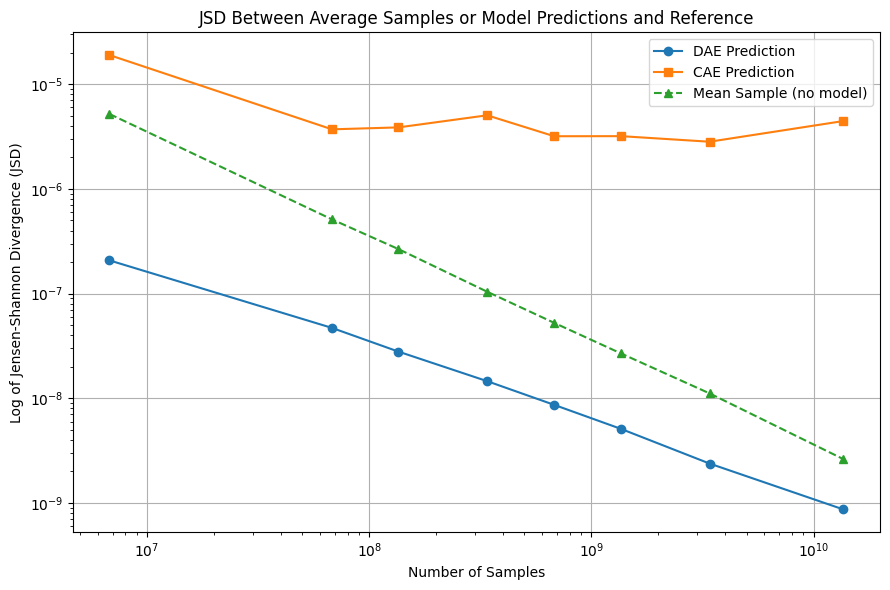

In [11]:
# === Plotting in Jupyter ===
plt.figure(figsize=(9, 6))
plt.loglog(n_values, (dae_jsd), marker='o', label='DAE Prediction')
plt.loglog(n_values, (cae_jsd), marker='s', label='CAE Prediction')
plt.loglog(n_values, (avg_sample_jsd), marker='^', linestyle='--', label='Mean Sample (no model)')

plt.xlabel("Number of Samples")
plt.ylabel("Log of Jensen-Shannon Divergence (JSD)")
plt.title("JSD Between Average Samples or Model Predictions and Reference")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import os
import re
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import register_keras_serializable

# === Custom Components ===
@register_keras_serializable(package="Custom")
class Renormalize(tf.keras.layers.Layer):
    def __init__(self, target_sum=8.0, **kwargs):
        super().__init__(**kwargs)
        self.target_sum = target_sum

    def call(self, inputs):
        x_sum = tf.reduce_sum(inputs, axis=[1, 2, 3], keepdims=True)
        return inputs / (x_sum + 1e-8) * self.target_sum

    def get_config(self):
        config = super().get_config()
        config.update({'target_sum': self.target_sum})
        return config

@register_keras_serializable(package="Custom")
def jensen_shannon_divergence_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    m = 0.5 * (y_true + y_pred)
    return 0.5 * tf.reduce_mean(
        tf.keras.losses.KLDivergence()(y_true, m) +
        tf.keras.losses.KLDivergence()(y_pred, m)
    )


# === Find models ===
model_files = [f for f in os.listdir('.') if re.match(r'\d+_(DAE|CAE)\.keras$', f)]
model_dict = {}
for f in model_files:
    match = re.match(r'(\d+)_(DAE|CAE)\.keras$', f)
    if match:
        n, model_type = match.groups()
        n = int(n)
        if n not in model_dict:
            model_dict[n] = {}
        model_dict[n][model_type] = f

combined_results = {}

for n_samples in sorted(model_dict.keys()):
    models = model_dict[n_samples]
    print(f"\nProcessing models for {n_samples} samples...")
    
    if 'DAE' not in models or 'CAE' not in models:
        print(f"Missing models for {n_samples}. Skipping.")
        continue

    sample_file = f"{n_samples}_sample_density.npy"
    if not os.path.exists(sample_file):
        print(f"Missing mean sample file: {sample_file}")
        continue

    dae = load_model(models['DAE'], compile=False)
    cae = load_model(models['CAE'], compile=False)
    avg_sample = np.load(sample_file)

    num_steps = 1000000 // 1000 - 1
    Base_JSD = np.zeros((num_steps, 1))
    DAE_JSD = np.zeros((num_steps, 1))
    CAE_JSD = np.zeros((num_steps, 1))

    avg = None
    counter = -1

    for i in range(1000, 1000000, 1000):
        counter += 1
        sample = stochastic_density(ref_d, i)
        #print(sample.shape,"sample")
        test = np.sum(sample, axis=2)  # shape: (1, 64, 64)
        #print(test.shape,"!!!!!!!!!!!")

        if counter == 0:
            avg = test
        else:
            avg += test

        test_reshaped = test.reshape(-1, 64, 64, 1)

        Base_JSD[counter] = jensen_shannon_divergence_loss(test[0].copy(), minorized_ref_d.copy()).numpy()
        DAE_JSD[counter] = jensen_shannon_divergence_loss(
            dae.predict(test_reshaped)[0, :, :, 0], minorized_ref_d.copy()).numpy()
        CAE_JSD[counter] = jensen_shannon_divergence_loss(
            cae.predict(test_reshaped)[0, :, :, 0], minorized_ref_d.copy()).numpy()

    avg = avg / counter
    avg_prediction = dae.predict(avg.reshape(-1, 64, 64, 1))[0, :, :, 0]
    avg_JSD = jensen_shannon_divergence_loss(avg_prediction, minorized_ref_d.copy()).numpy()
    AVG_TOTAL_JSD = jensen_shannon_divergence_loss(avg_sample, minorized_ref_d.copy()).numpy()

    x_vals = np.arange(num_steps) * 1000

    # Store for combined plot
    combined_results[n_samples] = {
        "x": x_vals,
        "base": np.log(Base_JSD.flatten()),
        "dae": np.log(DAE_JSD.flatten()),
        "cae": np.log(CAE_JSD.flatten()),
        "avg_JSD": np.log(avg_JSD),
        "AVG_TOTAL_JSD": np.log(AVG_TOTAL_JSD)
    }

    # Plot individual
    plt.figure(figsize=(7, 5))
    plt.plot(x_vals, np.log(Base_JSD), label='Base JSD')
    plt.plot(x_vals, np.log(DAE_JSD), label='DAE JSD')
    plt.plot(x_vals, np.log(CAE_JSD), label='CAE JSD')

    plt.axhline(np.log(avg_JSD), color='black', linestyle='--', label='avg_JSD')
    plt.axhline(np.log(AVG_TOTAL_JSD), color='purple', linestyle='-.', label='AVG_TOTAL_JSD')

    plt.text(x_vals[-1], np.log(avg_JSD), f'avg_JSD={avg_JSD:.4e}', color='black', ha='right')
    plt.text(x_vals[-1], np.log(AVG_TOTAL_JSD), f'AVG_TOTAL_JSD={AVG_TOTAL_JSD:.4e}', color='purple', ha='right')

    plt.xlabel("Sample Index (×1000)")
    plt.ylabel("log(JSD)")
    plt.title(f"JSD vs Samples - {n_samples} Samples")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"JSD_plot_{n_samples}.png")
    plt.close()

# Combined plot
plt.figure(figsize=(10, 6))
for n_samples, result in sorted(combined_results.items()):
    plt.plot(result["x"], result["dae"], label=f"DAE {n_samples}")
    plt.plot(result["x"], result["cae"], linestyle='dashed', label=f"CAE {n_samples}")

plt.xlabel("Sample Index (×1000)")
plt.ylabel("log(JSD)")
plt.title("Comparison of JSD Scores Across Sample Sizes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Combined_JSD_plot.png")
plt.show()



Processing models for 6773900 samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━

In [13]:
print("here")

here


In [8]:
print(ref_d.shape)

(64, 64, 64)
